In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import h5py
from scipy import interpolate
import pandas as pd
import yaml
import geopandas as gp
import time
import pandas as pd
from geopy.distance import great_circle
import folium
import h5py
from scipy.signal import butter, lfilter

from scipy.spatial import ConvexHull
from scipy.interpolate import griddata
from shapely.geometry import Point, Polygon

/tmp/ipykernel_497814/3020178249.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
import sys
sys.path.append(r'../tools_F-J/')
from toollib_standard import maplib
from toollib_standard import mathlib
from toollib_standard import filelib
from toollib_standard import stacklib
from toollib_standard import plotlib

In [3]:
flag_project = 1

if flag_project == 0:
    file_project = 'a-project.yml'
elif flag_project == 1:
    file_project = 'a-project_repar.yml'
elif flag_project == 2:
    file_project = 'a-project_voro.yml'
    
with open(file_project, 'r', encoding='utf-8') as f:
    proj = yaml.load(f.read(), Loader=yaml.FullLoader)
name_project = proj['name']
name_project = 'project_repartition_v4.0/output_repar_v9.5_01--10-16Hz/'

In [4]:
with open('0_config.yml', 'r', encoding='utf-8') as f:
    dir_config = yaml.load(f.read(), Loader=yaml.FullLoader)
dir_project_workspace = dir_config['dir_project_workspace']
dir_CC_workspace = dir_config['dir_CC_workspace']
print('dir_CC_workspace: ', dir_CC_workspace)
print('dir_project_workspace: ', dir_project_workspace)
dir_project = os.path.join(dir_project_workspace, name_project)
print('dir_project: ', dir_project)

dir_CC_workspace:  ./
dir_project_workspace:  ./
dir_project:  ./project_repartition_v4.0/output_repar_v9.5_01--10-16Hz/


In [5]:
filename = dir_project+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic = yaml.load(f.read(), Loader=yaml.FullLoader)
filename_bi = dir_project+'Basic_info.npy'
info_basic_bi = np.load(filename_bi, allow_pickle='TRUE').item()      # setting dictionary

In [6]:
dir_CC = dir_CC_workspace + info_basic['rdir_CC']
dir_ds = dir_project + info_basic['rdir_ds']
dir_partition = dir_project + info_basic['rdir_partition']
dir_image = dir_project + info_basic['rdir_image'] + 'paper_tomo/'
dir_disp = dir_project + info_basic['rdir_disp_model']
if os.path.exists(dir_image) == False:
    os.makedirs(dir_image)

In [7]:
stalistname_all = info_basic['stalistname_all']
stainfo = pd.read_excel(stalistname_all)
nsta_all = len(stainfo.iloc[:,0])
StationPairs_all = mathlib.GetStationPairs(nsta_all)
nPairs_all = int(len(StationPairs_all)/2)
stalist_all = stainfo['Station'].tolist()
lat_stations_all = stainfo['latitude'].tolist() 
lon_stations_all = stainfo['longitude'].tolist()

In [8]:
stations_partition = {}
lat_stations_partition = {}
lon_stations_partition = {}
lat_centroid_partition = []
lon_centroid_partition = []
for key in info_basic['key_subworks']:
    filepath = dir_partition + str(key) + '.txt'
    stations_this, lat_stations_this, lon_stations_this = np.loadtxt(filepath, dtype='str' , unpack=True)
    stations_partition[key] = stations_this
    lat_stations_partition[key] = lat_stations_this.astype(float)
    lon_stations_partition[key] = lon_stations_this.astype(float)
    lat_centroid_partition.append(np.mean(lat_stations_this.astype(float)))
    lon_centroid_partition.append(np.mean(lon_stations_this.astype(float)))

In [9]:
f_list = [5,10,13]
phase = {}
for f in f_list:
    phase[f] = []
for key in info_basic['key_subworks']:
    disp = np.loadtxt(dir_disp + 'disp_model_'+key+'.txt')
    disp = disp[disp[:,2] == 0]
    for f in f_list:
        phase[f].append(disp[disp[:,0]==f][0][1])

In [10]:
faults = np.load('clark_faults.npy', allow_pickle='TRUE').item()
name_ref, lat_fault_infer, lon_fault_infer = np.loadtxt('clark_fault_inferred.txt',dtype='str' , unpack=True,delimiter=',')
lon_fault_infer = lon_fault_infer.astype(float)
lat_fault_infer = lat_fault_infer.astype(float)

### Partition

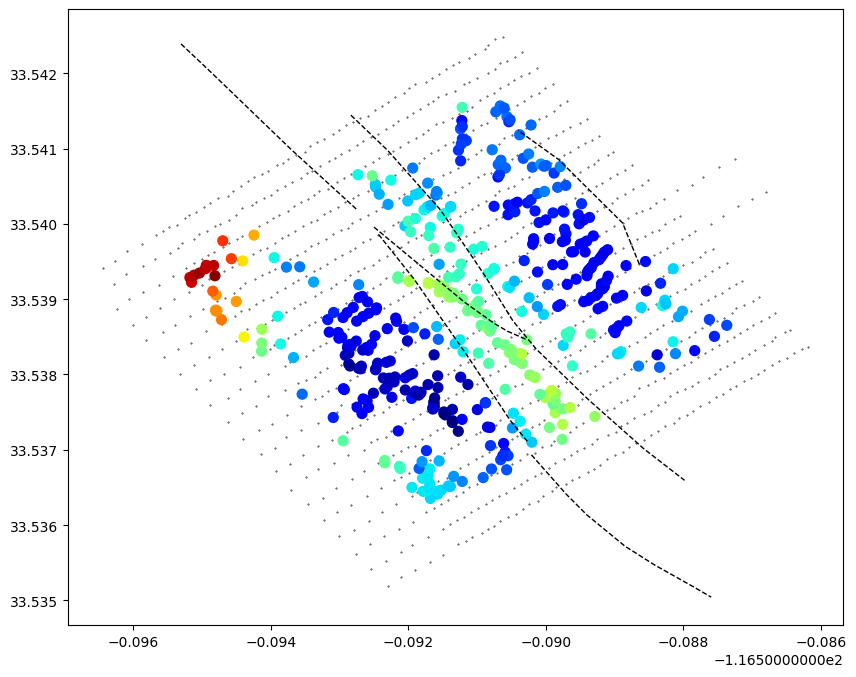

In [11]:
fig = plt.figure(figsize=(10,8))
ax_partition = fig.add_subplot(1,1,1)
ax_partition.scatter(lon_stations_all,lat_stations_all,marker='.',c = 'k',s = 0.5)
for j in range(len(faults)):
    if j == 0:
        ax_partition.plot(faults['clark'+str(j+1)]['lon'], faults['clark'+str(j+1)]['lat'], 'k--',lw = 1)
    else:
        ax_partition.plot(faults['clark'+str(j+1)]['lon'], faults['clark'+str(j+1)]['lat'], 'k--',lw = 1)
ax_partition.plot(lon_fault_infer,lat_fault_infer,'k--',lw = 1)
ax_partition.scatter(lon_centroid_partition,lat_centroid_partition,marker='o',c  = phase[f_list[2]],s = 50, cmap = 'jet')